# PPI Network Graph Preparation

#### Introduction

Filter needed PPI data for this project. Convert PPI data into network graph, clean and removed unneeded network edges.

Input:	PPI network data in json format 

Process:	
-	filter only data from ‘String’ as PPI network data
-	remove interaction records without gene ID
-	convert data into network graph
-	data checking and cleaning

    o	check and remove self looping edges    
    o	remove low score edges below the predefined threshold
-	visualise the degree distribution of the graph

Output:	
-	full network of the PPI, in pickle format
-	the largest subgraph of the PPI, in pickle format

Quality control:	
- Check the number of record, before and after removal of nodes. 
- Verify the change of number of nodes and edges are with known reason. 
- Verify by graph visualisation that the pattern should make sense.

Remarks:	User can change to use other interaction data or use other threshold for other purpose


#### Import Libraries

In [2]:
import pandas as pd
import networkx as nx
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### Load PPI data

In [3]:
# convert the json data to dataframe
interactions = pd.read_json('open_targets_data\interaction.json')

In [4]:
# filter only the interaction data that is from STRING database which contain the Protein-to-Protein interaction
ppi = pd.DataFrame(interactions.loc[interactions['sourceDatabase'] == 'string'])
ppi

,sourceDatabase,targetA,intA,intABiologicalRole,targetB,intB,intBBiologicalRole,speciesA,speciesB,count,scoring
4065,string,ENSG00000004059,ENSP00000000233,unspecified role,ENSG00000057608,ENSP00000369538,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.209
4066,string,ENSG00000004059,ENSP00000000233,unspecified role,ENSG00000175311,ENSP00000308772,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.175
4067,string,ENSG00000004059,ENSP00000000233,unspecified role,ENSG00000198055,ENSP00000433511,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.197
4068,string,ENSG00000003056,ENSP00000000412,unspecified role,ENSG00000106976,ENSP00000362014,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.904
4069,string,ENSG00000004478,ENSP00000001008,unspecified role,ENSG00000114867,ENSP00000416255,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.348
...,...,...,...,...,...,...,...,...,...,...,...
12172946,string,ENSG00000100129,ENSP00000485663,unspecified role,ENSG00000165275,ENSP00000297994,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",1,0.171
12172947,string,ENSG00000100129,ENSP00000485663,unspecified role,ENSG00000146830,ENSP00000275732,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.206
12172948,string,ENSG00000100129,ENSP00000485663,unspecified role,ENSG00000107581,ENSP00000358140,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",4,0.999
12172949,string,ENSG00000100129,ENSP00000485663,unspecified role,ENSG00000163584,ENSP00000346080,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.911


#### Data Checking and Cleaning

In [34]:
# define helper functions to check if there is self-looping within a network graph

def has_self_loop(graph):
    '''
    check if there is self interacting nodes
    parameter: 
        graph: networkx graph object
    return 
        True: if there is self-interacting node
        False: if there is no self-interacting node
    '''
    for node in graph.nodes():
        if node in graph.neighbors(node):
            return True
    return False

# define helper functions to retrieve the list of self-looping nodes within a network graph
def nodes_with_self_loop(graph):
    '''
    get the nodes that is self-interacting
    parameter: 
        graph: networkx graph object
    return: 
        list, a list of nodes that are self-interacting
    '''
    nodes_with_loop = []
    for node in graph.nodes():
        if node in graph.neighbors(node):
            nodes_with_loop.append(node)
    return nodes_with_loop

# define helper functions to plot log log graph for the network degree distribution
def plot_log_log_degree_dist(graph):
    '''
    plot the log log degree distribution from the graph object
    parameter: 
        G: networkx graph object
    return: 
        list, a list of nodes that are self-interacting
    '''
    degree_of_each_node = [v for k,v in nx.degree(graph)]
    uq_degree_vals = sorted(set(degree_of_each_node))
    frequency_for_each_uq_degree_val = [degree_of_each_node.count(x) for x in uq_degree_vals]

    x = np.asarray(uq_degree_vals, dtype = float)
    y = np.asarray(frequency_for_each_uq_degree_val, dtype = float)

    logx = np.log10(x)
    logy = np.log10(y)

    plt.figure(figsize=(10,10))
    plt.xlim(min(logx), max(logx))
    plt.xlabel('log10 (Degree)')
    plt.ylabel('log10 (Number of nodes)')
    plt.title('Degree Distribution of Network')
    out_degree_dist = plt.plot(logx, logy, 'o')
    
    return None

In [6]:
# check if the the ppi targets start with non ENSG id (ENSG are for human genes ID)

not_ENSG_series = ppi[~ppi['targetA'].str.startswith('ENSG')]

# empty set means all targets are start with ENSG
len(not_ENSG_series)

0

In [10]:
# drop record if the 'targetB' is empty

ppi_no_emptyB = ppi.dropna(subset=['targetB'])

In [11]:
ppi_no_emptyB

,sourceDatabase,targetA,intA,intABiologicalRole,targetB,intB,intBBiologicalRole,speciesA,speciesB,count,scoring
4065,string,ENSG00000004059,ENSP00000000233,unspecified role,ENSG00000057608,ENSP00000369538,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.209
4066,string,ENSG00000004059,ENSP00000000233,unspecified role,ENSG00000175311,ENSP00000308772,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.175
4067,string,ENSG00000004059,ENSP00000000233,unspecified role,ENSG00000198055,ENSP00000433511,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.197
4068,string,ENSG00000003056,ENSP00000000412,unspecified role,ENSG00000106976,ENSP00000362014,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.904
4069,string,ENSG00000004478,ENSP00000001008,unspecified role,ENSG00000114867,ENSP00000416255,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.348
...,...,...,...,...,...,...,...,...,...,...,...
12172946,string,ENSG00000100129,ENSP00000485663,unspecified role,ENSG00000165275,ENSP00000297994,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",1,0.171
12172947,string,ENSG00000100129,ENSP00000485663,unspecified role,ENSG00000146830,ENSP00000275732,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.206
12172948,string,ENSG00000100129,ENSP00000485663,unspecified role,ENSG00000107581,ENSP00000358140,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",4,0.999
12172949,string,ENSG00000100129,ENSP00000485663,unspecified role,ENSG00000163584,ENSP00000346080,unspecified role,"{'mnemonic': 'human', 'scientific_name': 'Homo...","{'mnemonic': 'human', 'scientific_name': 'Homo...",2,0.911


In [12]:
# conver the ppi data into network graph, and set the edge attribute with values under 'scoring'

ppi_graph = nx.from_pandas_edgelist(ppi_no_emptyB, source='targetA', target='targetB', edge_attr=['scoring'])

In [13]:
# export the ppi_graph as binary file for future use

with open('data\ppi\ppi_graph.gpickle', 'wb') as f:
    pickle.dump(ppi_graph, f, pickle.HIGHEST_PROTOCOL)

In [4]:
# check how many largest connected component in teh network (subgraph)
components = nx.connected_components(ppi_graph)
largest_component = max(components, key=len)
num_components = nx.number_connected_components(ppi_graph)
num_components

1

#### Remove edges with interaction scores below a predefined threshold

In [16]:
# set the threshold to filer edges of low confidence score
PPI_SCORE_TH = 0.7

# identify edges to remove
edges_to_remove = [(u, v) for u, v, w in ppi_graph.edges(data='scoring') if w < PPI_SCORE_TH]

# create a copy of the ppi_graph
ppi_removed_low_edge = ppi_graph.copy()

# remove low edges below the threshold
ppi_removed_low_edge.remove_edges_from(edges_to_remove)

In [17]:
# compare the number of records before and after the removal

print("original PPI")
print("Number of nodes:", ppi_graph.number_of_nodes())
print("Number of edges:", ppi_graph.number_of_edges())

print("removed low confidence ", PPI_SCORE_TH)
print("Number of nodes:", ppi_removed_low_edge.number_of_nodes())
print("Number of edges:", ppi_removed_low_edge.number_of_edges())

original PPI
Number of nodes: 18451
Number of edges: 5479182
removed low confidence  0.7
Number of nodes: 18451
Number of edges: 395373


In [19]:
# check if there are nodes interact with itself
has_self_loop(ppi_removed_low_edge)

True

In [21]:
# get the largest connected component in the network after removal of low score edges
components = nx.connected_components(ppi_removed_low_edge)
largest_component_removed_low_edge = max(components, key=len)
largest_subgraph_removed_low_edge = ppi_removed_low_edge.subgraph(largest_component_removed_low_edge)

In [23]:
# retrieve the nodes that have multiple proteins and have interaction with itself 

nodes_with_self_loop(largest_subgraph_removed_low_edge)

['ENSG00000213999',
 'ENSG00000114126',
 'ENSG00000225830',
 'ENSG00000234906',
 'ENSG00000137843',
 'ENSG00000196136',
 'ENSG00000158747',
 'ENSG00000128271',
 'ENSG00000157654',
 'ENSG00000080910']

In [13]:
# look up the edges with self interaction

self_interact_nodes = [(u, v) for u, v in ppi_removed_low_edge.edges() if u == v]

self_interact_nodes


[('ENSG00000213999', 'ENSG00000213999'),
 ('ENSG00000114126', 'ENSG00000114126'),
 ('ENSG00000225830', 'ENSG00000225830'),
 ('ENSG00000234906', 'ENSG00000234906'),
 ('ENSG00000137843', 'ENSG00000137843'),
 ('ENSG00000196136', 'ENSG00000196136'),
 ('ENSG00000158747', 'ENSG00000158747'),
 ('ENSG00000128271', 'ENSG00000128271'),
 ('ENSG00000157654', 'ENSG00000157654'),
 ('ENSG00000080910', 'ENSG00000080910')]

In [26]:
# remove the self-interacting edges 

ppi_removed_low_edge_and_self_loop = ppi_removed_low_edge.copy()
ppi_removed_low_edge_and_self_loop.remove_edges_from(self_interact_nodes)

In [27]:
print("original PPI")
print("Number of nodes:", ppi_graph.number_of_nodes())
print("Number of edges:", ppi_graph.number_of_edges())

print("removed low confidence ", PPI_SCORE_TH)
print("Number of nodes:", ppi_removed_low_edge.number_of_nodes())
print("Number of edges:", ppi_removed_low_edge.number_of_edges())

print("removed self loop nodes ")
print("Number of nodes:", ppi_removed_low_edge_and_self_loop.number_of_nodes())
print("Number of edges:", ppi_removed_low_edge_and_self_loop.number_of_edges())

original PPI
Number of nodes: 18451
Number of edges: 5479182
removed low confidence  0.7
Number of nodes: 18451
Number of edges: 395373
removed self loop nodes 
Number of nodes: 18451
Number of edges: 395363


In [29]:
# check the number of components in the network

num_components = nx.number_connected_components(ppi_removed_low_edge_and_self_loop)
num_components

2109

#### Obtain the largest subgraph from the PPI network

In [30]:
# obtain thhe largest connected component
components = nx.connected_components(ppi_removed_low_edge_and_self_loop)
largest_component = max(components, key=len)
largest_subgraph = ppi_removed_low_edge_and_self_loop.subgraph(largest_component)

In [31]:
# export the largest subgraph for future use
with open('data\ppi\largest_subgraph.gpickle', 'wb') as f:
    pickle.dump(largest_subgraph, f, pickle.HIGHEST_PROTOCOL)

#### Validating the Largetest Subgraph Details

In [32]:
# check if there is any self-looping 

has_self_loop(largest_subgraph)

False

In [33]:
# check if the edge attribut 'scoring' remains intact 

has_weights = any('scoring' in data for _, _, data in largest_subgraph.edges(data=True))
has_weights

True

largest connected component: 
Number of nodes: 16210
Number of edges: 395211


(array([1.4449e+04, 1.3750e+03, 3.1300e+02, 6.3000e+01, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([1.0000e+00, 1.3960e+02, 2.7820e+02, 4.1680e+02, 5.5540e+02,
        6.9400e+02, 8.3260e+02, 9.7120e+02, 1.1098e+03, 1.2484e+03,
        1.3870e+03]),
 <BarContainer object of 10 artists>)

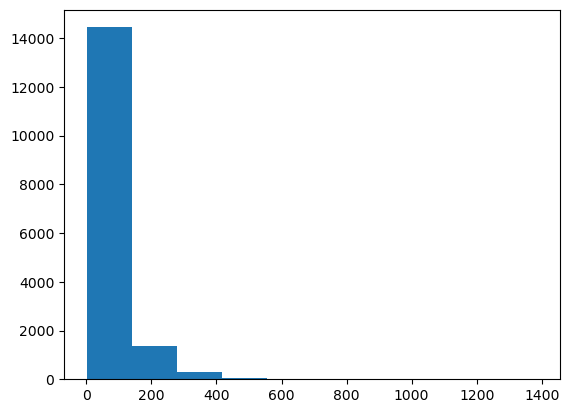

In [35]:
# display the details of the largest subgraph

print("largest connected component: ")
print("Number of nodes:", largest_subgraph.number_of_nodes())
print("Number of edges:", largest_subgraph.number_of_edges())

plt.hist([v for k,v in nx.degree(largest_subgraph)])

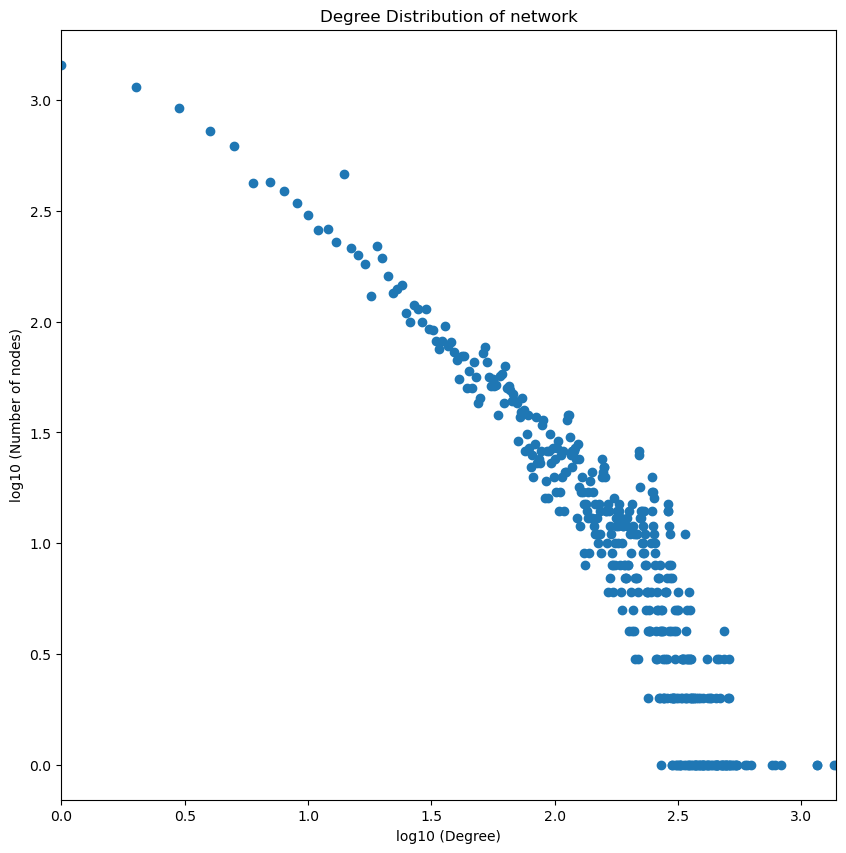

In [37]:
# visualise the degree of the largest subgraph

plot_log_log_degree_dist(largest_subgraph)